to check:
- Try chi-square test for among-variables & each variable-target to see they are highly related or not.
https://towardsdatascience.com/hypothesis-testing-in-machine-learning-using-python-a0dc89e169ce
<br><br>
- Try converting the features into categorical features to see if the result changes.
=> when dtype="category", chi-square test couldn't be done due to:
TypeError: Neither the `x` nor `y` variable appears to be numeric.
<br><br>
- Try feature augmentation (sigmoid, tanh, etc.); search term "python feature augmentation"
<br><br>
- Try bagging:
<br>** Bagging, also known as bootstrap aggregation, is the ensemble learning method that is commonly used to reduce variance within a noisy dataset. In bagging, a random sample of data in a training set is selected with replacement—meaning that the individual data points can be chosen more than once.
<br>** Random Forest Classifier has several decision trees trained on the various subsets. This algorithm is a typical example of a bagging algorithm. Random Forests uses bagging underneath to sample the dataset with replacement randomly.
<br><br>
other notes:
- Exclude correlation part. Keep K-fold cross validation.
- Keep train-test ratio as 8:2.
- Try with simpler models first. Don't make it too complex as the data set is small and simple.

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import random

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from skfeature.function.similarity_based import fisher_score

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from scipy import stats
from scipy.stats.contingency import expected_freq
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE

import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

In [24]:
survey_df = pd.read_csv("C:/Users/Admin/Documents/GitHub/NlupKgfEgSOdYRuv/data/ACME-HappinessSurvey2020.csv")
print(survey_df.head(), "\n")
print(survey_df.info(), "\n")
survey_df.describe()

   Y X1 X2 X3 X4 X5 X6
0  0  3  3  3  4  2  4
1  0  3  2  3  5  4  3
2  1  5  3  3  3  3  5
3  0  5  4  3  3  3  5
4  0  5  4  3  3  3  5 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Y       126 non-null    category
 1   X1      126 non-null    category
 2   X2      126 non-null    category
 3   X3      126 non-null    category
 4   X4      126 non-null    category
 5   X5      126 non-null    category
 6   X6      126 non-null    category
dtypes: category(7)
memory usage: 2.2 KB
None 



,Y,X1,X2,X3,X4,X5,X6
count,126,126,126,126,126,126,126
unique,2,4,5,5,5,5,5
top,1,5,3,3,4,4,5
freq,69,65,42,55,53,50,57


TypeError: Neither the `x` nor `y` variable appears to be numeric.

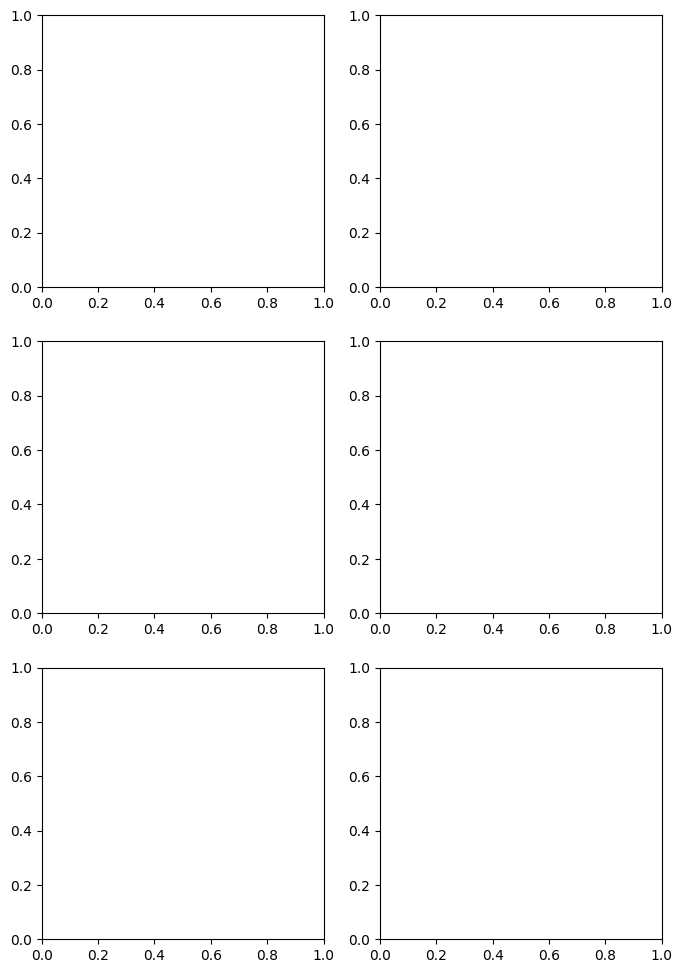

In [25]:
significance_level = 0.05

chi_independence_df = pd.DataFrame(columns=[
    "Independent Variable",
    "Chi-square",
    "P-value",
    "Null Hypothesis",
    f"Reject Null Hypothesis at alpha={significance_level}?"
    ])

fig, axes = plt.subplots(3, 2, figsize=(8,12))
for i, col in enumerate(survey_df.drop("Y", axis=1).columns):
    sns.barplot(survey_df, x=col, y="Y", ax=axes[i//2, i%2])
    x = survey_df[col]
    y = survey_df["Y"]

    contingency_table = pd.crosstab(x, y)
    print(f'Contingecy table for {col} and Y:')
    print(contingency_table, "\n")

    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    print(f'Expected frequencies for {col} and Y:')
    print(expected)

    """"
    1. Perform Chi-square test of goodness of fit and print out the result.
    """
    chi_goodness_of_fit_result = stats.chisquare(x)

    goodness_of_fit_null_hypothesis = f'There is no significant difference between {col} and the expected frequencies'
    if chi_goodness_of_fit_result.pvalue <= significance_level:
        goodness_of_fit_result = f""""
Null hypothesis: {goodness_of_fit_null_hypothesis}
Chi-square statistic: {chi_goodness_of_fit_result.statistic}
P-value: {chi_goodness_of_fit_result.pvalue}

Reject the null hypothesis
=> {col} is not representative of the population at alpha={significance_level}."""
    else: # Fail to reject the null hypothesis
        goodness_of_fit_result = f"""
Null hypothesis: {goodness_of_fit_null_hypothesis}
Chi-square statistic: {chi_goodness_of_fit_result.statistic}
P-value: {chi_goodness_of_fit_result.pvalue}

Failed to reject the null hypothesis
=> {col} is representative of the population at alpha={significance_level}"""
    print(goodness_of_fit_result)

    """"
    2. Perform Chi-Square test of Independence and store the result in a dataframe.
    """
    independence_null_hypothesis = f'{col} and Y are independent of each other'
    if p <= significance_level:
        independence_result = "Yes"
    else:
        independence_result = "No"

    chi_independence_df = chi_independence_df.append(
        {
        "Independent Variable": col,
        "Chi-square": chi2,
        "P-value": p,
        "Null Hypothesis": independence_null_hypothesis,
        f"Reject Null Hypothesis at alpha={significance_level}?": independence_result
        },
        ignore_index=True
    )
    print("--------------------------------------")

print("Result of Chi-square test of independence:")
chi_independence_df

Based on the chi-square test of goodness of fit, all independent variables are representative of the population.

Hoewever, based on the chi-square test of independence, only X1 is associated with target Y and the rest are independent of Y at a significance level of 0.05, meaning with 95% of confidence X2-X6 are not associated with Y, thus would not be helpful in predicting Y.

If we increase the significance level to 0.1, then we can consider X6 is also associated with target Y with 90% of confidence, meaning it could be helpful in predicting Y too, in addition to X1.

Only using 1 out of 6 variables for supervised learning might not result in a robust model (since we are discarding 5/6 of the features), I would try to train a model with two features, that is X1 and X6 based on the chi-square tests.

- Try feature augmentation (sigmoid, tanh, etc.); search term "python feature augmentation"
- after that, try logistic regression cv, random forest, randomized search cv.